In [6]:
import torch 
import torch.nn as nn 
import torchsde
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 
import pandas as pd 
from sklearn.cluster import KMeans

%matplotlib inline 

In [7]:
sb.set_theme() 

In [8]:
train_path = "CMAPSS\\train_FD001.txt"
test_path = "CMAPSS\\test_FD001.txt"
testRUL_path = "CMAPSS\\RUL_FD001.txt"

train = pd.read_csv(train_path, parse_dates=False, delimiter=" ", decimal=".", header=None)
test  = pd.read_csv(test_path, parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv(testRUL_path, parse_dates=False, decimal=".", header=None)

In [9]:
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ["train", "test"]

# drop the columns that consist of missing values 
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'
        , 's9','s10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

train.columns = cols
test.columns = cols

In [10]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
train["TTF"] = train["maxcycles"] - train["cycles"]
train.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,maxcycles,TTF
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [11]:
test["TTF"] = test["cycles"]
for i in range(test["unit"].max()):
    test.loc[test["unit"]==i+1, "TTF"] = np.array(test[test["unit"]==i+1].cycles[::-1] + RUL[0][i] - 1)

test.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,TTF
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [15]:
class data_prep():
    def __init__(self, train, test):
        """
        INPUTS:

            train: Type = Pandas Dataframe 
                trianing data (operating conditions and sensors)

            test: Type = Pandas Dataframe
                testing data (operating conditions and sensors)
        """
        self.train = train 
        self.test = test 

    def op_normalize(self, K=1): 
        """
        Normalizes the data based on operating mode clusters catogorized and found with 
        K-means clustering. 

        x_n = (x - op_mean) / op_std 

        This is done on the training data and the means and stdevs are saved and used to 
        normalize the testing data to keep consistant. 

        where: 
            x = sensor value 
            op_mean = mean of the operating mode cluster "x" is in 
            op_std = standard deviation of the operating mode cluster "x" is in 
            x_n = normalized sensor value 

        INPUTS:
            K: Type = int 
                amount of clusters/operating modes for K-means clustering 
                *Note if K=1 then this is standard normalization 

        OUTPUT: 
            data_norm: Type, Pandas DataFrame 
                same as the input dataframe but the sensor values are 
                normalized based on the mean and standard deviation of the operating 
                class they are in 
        """
        data = self.train
        data_test = self.test

        # K-means clustering 
        op_set = [col for col in data.columns if col.startswith("op")]
        X = data[op_set].values
        self.kmeans = KMeans(n_clusters=K, n_init=10).fit(X)    # cluster using training data 

        # Append operating cluster id's to dataset 
        data_op = self.operating_modes(data)
        data_op_test = self.operating_modes(data_test)

        # operating modes needed to loop over 
        self.clusters = data_op["op_c"].max()

        # copy for later normalization
        data_n = data_op.copy()
        data_n_test = data_op_test.copy()

        # find the means and standard deviations of sensors in each opperating mode of training data 
        sensors = [col for col in data_n.columns if col.startswith("s")]
        self.means = []
        self.stds = [] 
        for c in range(0, self.clusters+1):
            sens = data_n[(data_n.op_c==c)][sensors]
            mean = sens.mean()
            std = sens.std()

            self.means.append(mean)
            self.stds.append(std)

        # use these means and stadard deviations to normalize the sensor values 
        drop_index = [[0]]
        for s in self.stds:
            if len(drop_index[0]) < len(s[s<1e-8]): # find the largest amount of sensors with a small stdev 
                drop_index = s[s<1e-8].index 

        if len(drop_index) == 1:
            if (drop_index) == [[0]]:
                None 
        else: 
            # drop sensor values with small standard deviation 
            for i in range(len(self.means)):
                self.means[i].drop(drop_index, inplace=True)
                self.stds[i].drop(drop_index, inplace=True)

            data_n = self.drop_sensors(data_n, drop_index)
            data_n_test = self.drop_sensors(data_n_test, drop_index)

            # drop sensors with 2 or less unique values 
            drop_index = self.drop_same(data_n)
            for i in range(len(self.means)):
                self.means[i].drop(drop_index, inplace=True)
                self.stds[i].drop(drop_index, inplace=True)

            data_n = self.drop_sensors(data_n, drop_index)
            data_n_test = self.drop_sensors(data_n_test, drop_index)

        # normalize the sensors for each unit in the dataset 
        data_n = self.norm(data_n)
        data_n_test = self.norm(data_n_test)

        return data_n, data_n_test 

    def operating_modes(self, data):
        """
        Use K-means to classify data into operating modes 
        """
        op_set = [col for col in data.columns if col.startswith("op")]
        X = data[op_set].values
        kmeans_pred = self.kmeans.predict(X)

        # append operating mode classifications to data 
        op_cluster = pd.DataFrame({"op_c": kmeans_pred})
        data_op = pd.concat([data, op_cluster], axis=1)

        return data_op

    def drop_sensors(self, data, drop_index):
        """
        Drops sensors based on index given (drop_index)
        """
        data.drop(drop_index, axis=1, inplace=True)

        return data

    def drop_same(self, data):
        """
        Returns the index to drop the sensors with only 2 or less unique values 
        in the series 
        """
        sensors = [col for col in data.columns if col.startswith("s")]
        drop_index = data[sensors].loc[:,data[sensors].nunique() < 3].columns

        return drop_index

    def norm(self, data):
        """
        normalize data based on the mean and standard deviation of the 
        operating condition it is apart of 
        """
        units = int(data["unit"].max())
        sensors = [col for col in data.columns if col.startswith("s")]
        for unit in range(1, units+1):
            for c in range(0, self.clusters+1):
                sens = data[(data.op_c==c) & (data.unit==unit)][sensors]
                sens = (sens - self.means[c]) / self.stds[c]
                data.loc[(data.op_c==c) & (data.unit==unit), sensors] = sens

        return data 

In [16]:
prep_class = data_prep(train, test)
ntrain, ntest = prep_class.op_normalize(K=1)    # K=1 normalization, K=6 operating condition norm 
ntrain.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s2,s3,s4,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,op_c
0,1,1,-0.0007,-0.0004,100.0,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,...,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,192,191,0
1,1,2,0.0019,-0.0003,100.0,-1.061754,0.211523,-0.643710,0.431920,-0.798074,...,1.174871,-0.363637,-0.642829,-0.275845,-0.781691,1.016503,1.236892,192,190,0
2,1,3,-0.0043,0.0003,100.0,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,...,1.364688,-0.919819,-0.551616,-0.649128,-2.073044,0.739873,0.503411,192,189,0
3,1,4,0.0007,0.0000,100.0,-0.661797,-1.261284,-0.784812,1.222798,0.188044,...,1.961255,-0.224592,-0.520163,-1.971617,-0.781691,0.352590,0.777773,192,188,0
4,1,5,-0.0019,-0.0002,100.0,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,...,1.052846,-0.780774,-0.521736,-0.339837,-0.136014,0.463242,1.059526,192,187,0


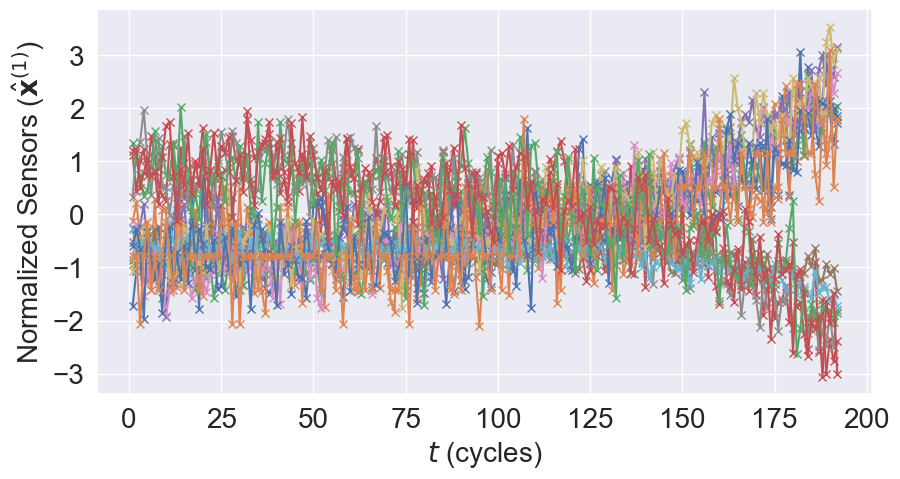

In [9]:
sensors = [col for col in ntrain.columns if col.startswith("s")]
unit = 1
plt.figure(figsize=(10,5))
plt.plot(ntrain[(ntrain.unit==unit)].cycles.values, ntrain[(ntrain.unit==unit)][sensors].values, marker='x')
plt.xlabel("$t$ (cycles)", fontsize=20)
plt.ylabel("Normalized Sensors ($\hat{\mathbf{x}}^{(1)}$)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [10]:
def prep_data(df, T, stride):
    sensors = [col for col in df.columns if col.startswith("s")]

    x = torch.tensor([])
    y = torch.tensor([])
    t = torch.tensor([])
    for unit in range(1, max(df.unit)+1):
        rul = df[df.unit==unit].TTF.values
        sen = df[df.unit==unit][sensors].values
        time = df[df.unit==unit].cycles.values

        # turn the current unit signal into a tensor of size (seq, dim)
        sen = torch.tensor(sen)
        rul = torch.tensor(rul).unsqueeze(-1)
        time = torch.tensor(time).unsqueeze(-1)

        # split entire sequences into 'N' time series blocks of size T, (N, T, dim)
        sen = sen.unfold(0, T, stride).permute(0,2,1)
        rul = rul.unfold(0, T, stride).permute(0,2,1)
        time = time.unfold(0, T, stride).permute(0,2,1)

        # if rul > 130 let rul = 130 if it is below 130 then rul = rul 
        rul = (rul > 130) * 130 + (rul <= 130) * rul

        x = torch.cat((x, sen), dim=0)
        y = torch.cat((y, rul), dim=0)
        t = torch.cat((t, time), dim=0)

    return x, y, t

x_train0, y_train0, t_train0 = prep_data(ntrain, 40, 1)

print(x_train0.shape)
print(y_train0.shape)
print(t_train0.shape)

torch.Size([16731, 40, 14])
torch.Size([16731, 40, 1])
torch.Size([16731, 40, 1])


In [11]:
def valid_set(x_train, y_train, t_train, split=0.2):
    rng = np.random.default_rng()

    valid_size = int(split * x_train.shape[0])
    total_No_idxs = x_train.shape[0] - 1
    # get a list of random integers to serve as indicies to extract a validation dataset 
    valid_set = list(rng.choice(total_No_idxs, size=valid_size, replace=False))

    # get the remaining possible integers to serve as the indicies for the training dataset 
    train_set = list(np.linspace(0, x_train.shape[0]-1, x_train.shape[0]))
    train_set = [x for x in train_set if x not in valid_set]

    # store new training and validation tensors/datasets
    x_valid = x_train[valid_set]
    y_valid = y_train[valid_set]
    t_valid = t_train[valid_set]
    x_train = x_train[train_set]
    y_train = y_train[train_set]
    t_train = t_train[train_set]

    return x_train, y_train, t_train, x_valid, y_valid, t_valid

x_train, y_train, t_train, x_valid, y_valid, t_valid = valid_set(x_train0, y_train0, t_train0)

print("x_train: ", x_train.shape)
print("x_valid: ", x_valid.shape)
print("y_train: ", y_train.shape)
print("y_valid: ", y_valid.shape)
print("t_train: ", t_train.shape)
print("t_valid: ", t_valid.shape)

x_train:  torch.Size([13385, 40, 14])
x_valid:  torch.Size([3346, 40, 14])
y_train:  torch.Size([13385, 40, 1])
y_valid:  torch.Size([3346, 40, 1])
t_train:  torch.Size([13385, 40, 1])
t_valid:  torch.Size([3346, 40, 1])


In [12]:
def prep_test(df, RUL):
    """
    Prepares input test data used once the network is trained 

    Inputs:
        df (pandas DataFrame): the dataframe with the input sensor data for each unit 
        RUL (pandas DataFrame): the dataframe with the corresponding RUL for each unit 

    Outputs:
        x (tensor): the sensors in a tensor format, size (1, seq, inputs)
        y (tensor): the RUL values at each time point (seq)
        t (tensor): corresponding times (1, seq, 1)
    """
    sensors = [col for col in df.columns if col.startswith("s")]
    RUL = RUL.values

    x = [] 
    y = [] 
    t = [] 
    for unit in range(1, max(df.unit)+1):
        sen = df[df.unit==unit][sensors].values
        rul_T = RUL[unit-1]
        time = df[df.unit==unit].cycles.values

        seq = sen.shape[0]          # observed sequence length 
        total_len = rul_T + seq     # total length if run to end of life

        rul = np.linspace(total_len-1, rul_T, seq)

        sen = torch.tensor(sen)
        rul = torch.tensor(rul)
        time = torch.tensor(time)

        rul = (rul > 130) * 130 + (rul <= 130) * rul

        x.append(sen.unsqueeze(0))
        y.append(rul.squeeze(-1))
        t.append(time.unsqueeze(-1).unsqueeze(0))

    return x, y, t    

test_list, test_tgts, test_time = prep_test(ntest, RUL)

print(test_list[0].shape)
print(test_tgts[0].shape)
print(test_time[0].shape)

torch.Size([1, 31, 14])
torch.Size([31])
torch.Size([1, 31, 1])


In [13]:
bs = 150

train_DataSet = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_DataSet, shuffle=True, batch_size=bs)

valid_DataSet = torch.utils.data.TensorDataset(x_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_DataSet, batch_size=bs)

# Networks

In [14]:
# ------------------
# Utils
# ------------------
def choose_nonlinearity(name):
  nl = None
  if name == 'tanh':
    nl = torch.tanh
  elif name == 'relu':
    nl = torch.relu
  elif name == 'sigmoid':
    nl = torch.sigmoid
  elif name == 'softplus':
    nl = torch.nn.functional.softplus
  elif name == 'selu':
    nl = torch.nn.functional.selu
  elif name == 'elu':
    nl = torch.nn.functional.elu
  elif name == 'swish':
    nl = lambda x: x * torch.sigmoid(x)
  else:
    raise ValueError("nonlinearity not recognized")
  return nl

# -------------------
# Neural Networks
# -------------------
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity='tanh'):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim, bias=None)

    for l in [self.linear1, self.linear2, self.linear3]:
      nn.init.orthogonal_(l.weight) # use a principled initialization

    self.nonlinearity = choose_nonlinearity(nonlinearity)

  def forward(self, x):
    h = self.nonlinearity( self.linear1(x) )
    h = h + self.nonlinearity( self.linear2(h) )
    return self.linear3(h)

# --------------
# Loss 
# --------------
def loss_KLD(mean1, logvar1, mean2, logvar2):
    """
    KL-divergance between 2 Gaussian distributions, given the mean and log-variance of 
    Gaussian 1 and Gaussian 2. 
    """
    loss = -0.5 * torch.sum(logvar1 - logvar2
    - torch.div(logvar1.exp() + (mean1 - mean2) ** 2, logvar2.exp() + 1e-10))
    return loss 

def loglike(x, mean, lvar):
    var = torch.exp(lvar) 
    return -0.5 * torch.log(2*(np.pi)*var) - (x - mean) ** 2 / (2*var)


In [15]:
class AugNSDE_DVAE(nn.Module):
    noise_type = 'diagonal'
    sde_type = 'stratonovich'
    def __init__(self, x_dim, z_dim, a_dim, h_dim, g_dim, hidden, dt, device, prior=None):
        """
        Inputs:
            x_dim (int): input data dimension 
            z_dim (int): latent dynamics dimension 
            a_dim (int): augmented dimension (extends latent dynamics dimsion)
            h_dim (int): forward RNN encoder hidden state dimension 
            g_dim (int): backward RNN encoder hidden state dimension 
            hidden (int): dimension of the hidden layer used in the MLP networks 
            dt (int): time difference used in the SDE solver 
            device (torch.device): cuda or cpu device 
            prior (function/class): a function with inputs (t,z) that describes prior dynamics 
                can be used if certain dynamics want to be used. 
                OR
                a class with a forward/call method with inputs (t,z) that describes prior dynamics. 
                This may be better as a class can define neural networks to be used in the forward method.
        """
        super().__init__()
        self.x_dim, self.h_dim, self.z_dim, self.a_dim = x_dim, h_dim, z_dim, a_dim
        self.device = device 
        self.dt = dt 

        # deterministic 
        self.rnn_h = nn.GRU(x_dim, h_dim, batch_first=True)
        self.rnn_g = nn.GRU(x_dim + h_dim, g_dim, batch_first=True)
        self.rnn_r = nn.GRU(1, h_dim, batch_first=True)

        # inference 
        self.z0_inf_net = MLP(g_dim + h_dim, hidden, (z_dim+a_dim)*2)

        # generative
        self.z0_net = MLP(g_dim, hidden, (z_dim+a_dim)*2)
        self.r_net = MLP(z_dim + a_dim + h_dim, hidden, 1 * 2)

        # NSDE
        self.diff = nn.Parameter(torch.randn(z_dim + a_dim)*0.1)
        self.drift = MLP(z_dim + a_dim, hidden, 1)
        self.prior = prior

    def sample(self, mean, logvar):
        std = torch.exp(2*logvar)
        eps = torch.randn_like(std)
        return torch.addcmul(mean, eps, std)

    def h(self, t, za):
        return self.prior(t, za)

    def f(self, t, za):
        """
        Neural drift function:

        Inputs:
            t (float): the 1D time tensor input to the ODE solver will be used to get this value 
            za (tensor): latent variable which moves according to the dynamics described here 
                (along with a concatenated augmented variable/s)

        Outputs:
            dzdt (tensor): the time derivative evaluated at the current state (z) and time (t)
        """
        bs, _ = za.shape
        
        z_dot = za[...,1:self.z_dim]
        z_T_dot = torch.tanh(self.drift(za))

        if self.a_dim > 0: 
            aug_dot = torch.zeros(bs, self.a_dim).to(self.device)   # augmented dim stays constant during time 
            dzdt = torch.cat((z_dot, z_T_dot, aug_dot), dim=-1)

        else:
            dzdt = torch.cat((z_dot, z_T_dot), dim=-1)

        return dzdt

    def g(self, t, za):
        return self.diff * za   # proportional diffusion

    def sample_stats(self, stats):
        """
        get mean and log-variance from a tensor containing the mean and log-var 

        Inputs: 
            stats (tensor): size (*, dim*2) containing mean and log-var, mean: [*,:dim], lvar: [*,dim:]
        """  
        dimX2 = stats.shape[-1]
        dim = dimX2 // 2 

        mean = stats[...,:dim]
        lvar = stats[...,dim:]
        return mean, lvar 

    def inference(self, xs, rs):
        """
        Inputs:
            xs (tensor): sequence of input data, size (bs, seq, x_dim)
            rs (tensor): sequence of RUL values, size (bs, seq, 1)

        Outputs:
            zs (tensor): sequence of latent variable trajectories from the inference model, size (bs, seq, z_dim)
            kl (tensor): KL diveregence between the 2 initial condition distributions (prior and inference), size (1)
            hs (tensor): RNN internal states which can be used to generate inputs, size (bs, seq, h_dim)
        """
        # --- set up variables ---
        bs, seq, x_dim = xs.shape 
        self.rs = rs 

        # --- smoothing ---
        hs, _ = self.rnn_h(xs)                          # forward RNN
        h_x = torch.cat((hs, xs), dim=-1)

        g_revs, _ = self.rnn_g(torch.flip(h_x, [1]))    # backward RNN 
        hs = torch.flip(g_revs, [1])        # x_{1:T}
        
        hrs, _ = self.rnn_r(rs)             # r_{1:T}
        hrs = torch.cat((hs, hrs), dim=-1)  # (x_{1:T}, r_{1:T})

        # --- Sample --- 
        z0_prior_stats = self.z0_net(hs[:,-1,:])
        z0_prior_mean, z0_prior_lvar = self.sample_stats(z0_prior_stats)

        z0_inf_stats = self.z0_inf_net(hrs[:,-1,:])
        z0_inf_mean, z0_inf_lvar = self.sample_stats(z0_inf_stats)
        
        z0 = self.sample(z0_inf_mean, z0_inf_lvar)

        # --- Dynamics ---
        ts = torch.linspace(1, self.dt * seq, seq).to(self.device)
        if self.prior == None:
            zs = torchsde.sdeint(self, z0, ts, dt=self.dt, adaptive=False, method="reversible_heun") 
            kl = z0.new_zeros(1)
            seq = 1.
        else:
            zs, kl = torchsde.sdeint(self, z0, ts, dt=self.dt, logqp=True, adaptive=False, method="reversible_heun") 
            kl = kl.mean(1).sum()   # kl, size (seq-1, bs) hence need to add to kl0

        zs = zs.permute(1,0,2)

        # --- Outputs ---
        kl0 = loss_KLD(z0_prior_mean, z0_prior_lvar, z0_inf_mean, z0_inf_lvar) / (bs)

        kl = (kl0 + kl) / seq

        return zs, kl, hs

    def forward(self, xs, rs):
        """
        Inputs:
            xs (tensor): sequence of input data, size (bs, seq, x_dim)
            rs (tensor): sequence of RUL values, size (bs, seq, 1)
        """

        zs, kl, hs = self.inference(xs, rs)

        # inputs for RUL est. 
        z_h = torch.cat((zs, hs), dim=-1)
        # generate rs_stats
        r_stats = self.r_net(z_h)

        r_mean = r_stats[...,:1]
        r_lvar = r_stats[...,1:]

        return r_mean, r_lvar, kl

    def get_loss(self, xs, rs):
        r_mean, r_lvar, kl = self.forward(xs, rs)
        
        rul_loss = -loglike(rs, r_mean, r_lvar).sum(1).mean()   # DVAE loss sums across time dimension 

        return kl, rul_loss

    def evaluate(self, xs, N=1): 
        """
        Use known input sequence to estimate RUL and return variables 
        for plotting.

        Inputs:
            xs (tensor): sequence of inputs, size (bs, seq, x_dim)
            N (int): number of samples 
        
        Outputs:
            r_mean (tensor): RUL estimates mean, size (bs, seq, x_dim)
            r_lvar (tensor): RUL estimates log-variance, size (bs, seq, 1)
            zs (tensor): latent sequences from prior SDE, size (bs, seq, z_dim)
        """
        # --- set up variables ---
        bs, seq, x_dim = xs.shape 

        # --- capture sequential information ---
        hs, _ = self.rnn_h(xs)                          # forward RNN
        h_x = torch.cat((hs, xs), dim=-1)

        g_revs, _ = self.rnn_g(torch.flip(h_x, [1]))    # backward RNN 
        hs = torch.flip(g_revs, [1])        # x_{1:T}

        # --- Sample --- 
        z0_prior_stats = self.z0_net(hs[:,-1,:])
        z0_prior_mean, z0_prior_lvar = self.sample_stats(z0_prior_stats)

        z0_prior_mean = torch.tile(z0_prior_mean.unsqueeze(0), dims=(N,1,1))
        z0_prior_lvar = torch.tile(z0_prior_lvar.unsqueeze(0), dims=(N,1,1))
        z0 = self.sample(z0_prior_mean, z0_prior_lvar)

        # --- Dynamics ---
        ts = torch.linspace(1, self.dt * seq, seq).to(self.device)
        z0 = z0.view(bs*N, z0.shape[-1])
        if self.prior == None:
            zs = torchsde.sdeint(self, z0, ts, dt=self.dt, adaptive=False, method="reversible_heun") 
        else:
            zs = torchsde.sdeint(self, z0, ts, dt=self.dt, adaptive=False, names={"drift": "h"}, method="reversible_heun") 

        zs = zs.permute(1,0,2)
        zs = zs.view(N, bs, seq, z0.shape[-1])

        # --- generate --- 
        # inputs for RUL est. 
        hs = torch.tile(hs.unsqueeze(0), dims=(N,1,1,1))
        z_h = torch.cat((zs, hs), dim=-1)
        # generate rs_stats
        r_stats = self.r_net(z_h)

        r_mean = r_stats[...,:1]
        r_lvar = r_stats[...,1:]

        return r_mean, r_lvar, zs


# Utils for Training and Testing 

In [16]:
class RunningAverage():
    def __init__(self):
        self.running_losses = {}
        self.names = [] 

    def add_key(self, names):
        # names are a list of strings for the dictionary keys containing losses
        for name in names:
            self.running_losses[name] = []
            self.running_losses[name + "_avg"] = 0 
            self.running_losses[name + "_std"] = 0
            
            self.names.append(name)

    def add_loss(self, loss, name):
        self.running_losses[name].append(loss.item())
        
    def avg_loss(self):
        for name in self.names:
            avg = np.array(self.running_losses[name]).mean()
            self.running_losses[name + "_avg"] = avg 

    def std_loss(self):
        for name in self.names:
            std = np.array(self.running_losses[name]).std()
            self.running_losses[name + "_std"] = std

    def reset_all(self):
        # reset all losses and counters to 0 
        for name in self.running_losses:
            self.running_losses[name] = [] 

    def get_avg_loss(self, name):
        return self.running_losses[name + "_avg"]

    def get_std_loss(self, name):
        return self.running_losses[name + "_std"]

In [17]:
def sliding_window(x, T):
    """
    Use a sliding window of length T, over the sequential data 

    Inputs:
        x (array): sequence to break into time windows, size (seq, dim)
        T (int): window size 

    Outputs:
        x_T (array): batch of time-windowed sequences, size (bs, seq, dim) 
    """
    T = int(T)
    if x.shape[0] < T:
        return x.unsqueeze(0)
    seq = x.shape[0] - T
    sub_windows = (
        torch.arange(T).unsqueeze(0) +
        torch.arange(seq + 1).unsqueeze(0).T
    )
    return x[sub_windows]

def diag_idx(array, idx):
    """
    returns the diagonal elements of a matrix 
    e.g. 
    
        [1, 2, 3
    A =  4, 5, 6
         7, 8, 9
         10,11,12]

    diag_idx(A, 1) = np.array([4, 2])
    diag_idx(A, 0) = np.array([1])
    diag_idx(A, 3) = np.array([10, 8, 6])
    """
    def relu(x):
        if x <= 0:
            return 0 
        else:
            return x 

    n = array.shape[0]
    m = array.shape[1]
    idx = int(idx)

    #if n == 1:
        #return x[]
    if n < m:
        a = n 
        n = m
        m = a  
        array = array.swapaxes(0,1) # shape (higher dim, lower dim)

    i_start = min(idx, n-1)
    j_start = relu(idx - (n-1))
    if idx >= m:
        j_end = m 
    else: 
        j_end = idx+1

    j_idxs = torch.arange(j_start, j_end, dtype=torch.long)
    size = j_idxs.shape[0]
    
    i_idxs = torch.linspace(i_start, i_start-size+1, size, dtype=torch.long)

    return array[i_idxs, j_idxs]

def win_to_seq(x_T):
    """
    Given a bunch of time windowed batches in order
    i.e. 
    x_T =  [[0, 1, 2, 3],
            [1, 2, 3, 4],
            [2, 3, 4, 5]
            etc...]
    returns the array that is a single sequence 
    i.e. 
    x = [0,1,2,3,4,5,...]

    * Note the overlapping terms are averaged

    e.g.
    diag_idx(x_T, 1).mean() = np.array([1, 1]).mean() = 1. 
    In this case we have the same values at each overlapping time point, but in 
    some cases (such as non-causal network estimates, this may not be the case)
    """
    bs = x_T.shape[0]
    T = x_T.shape[1]
    seq = bs + T - 1 
    
    xts = [diag_idx(x_T, i).mean(0) for i in range(seq)]
    x = torch.stack(xts)
    return x 

In [38]:
def train_model(train_loader, valid_loader, model, device, Beta=1., epochs=100, lr=1e-3, L2=1e-5, print_epochs=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=L2)
    model = model.to(device)
    loss_avg = RunningAverage()
    loss_avg.add_key(["train kl-div", "train rul_loss", "valid rul_loss"])
    PATH = "saved_models/AugNSDE_DVAE.pth"
    best_loss = 1e10

    for epoch in range(1,epochs+1):
        # reset running average counter and losses 
        loss_avg.reset_all()
        for xs, tgts in train_loader:
            xs = xs.to(device).float()
            tgts = tgts.to(device).float()

            # losses and backprop
            kl_div, rul_loss = model.get_loss(xs, tgts)

            # add losses to running average for returning to user 
            loss_avg.add_loss(kl_div, "train kl-div")
            loss_avg.add_loss(rul_loss, "train rul_loss")

            # compute loss 
            loss = Beta * kl_div + rul_loss

            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch == 1 or epoch % 10 == 0 or epoch == epochs:
            with torch.no_grad():
                for xs, tgts in valid_loader:
                    xs = xs.to(device).float()
                    tgts = tgts.to(device).float()

                    # get losses 
                    r_mean, _, _ = model.evaluate(xs) 

                    valid_rul_loss = torch.sqrt(((tgts - r_mean) ** 2).mean())

                    # add losses for returning to user
                    loss_avg.add_loss(valid_rul_loss, "valid rul_loss")


                # Average losses (instead of using the last loss of every training/validation set)
                loss_avg.avg_loss()

                # store losses in variables for readability 
                train_kl_div = loss_avg.get_avg_loss("train kl-div")
                train_rul_loss = loss_avg.get_avg_loss("train rul_loss")
                valid_rul_loss = loss_avg.get_avg_loss("valid rul_loss")
                
                avg_valid_loss = valid_rul_loss

                if avg_valid_loss < best_loss:
                    best_loss = avg_valid_loss
                    torch.save(model.state_dict(), PATH)    # save current best performing model 
                    if print_epochs == True:
                        print("Epoch: {}/{}, kl-div: {:.4f}, rul loss: {:.4f}, valid rul loss: {:.4f}, "\
                                    "New best loss: saving model ..."
                        .format(epoch, epochs, train_kl_div, np.sqrt(train_rul_loss), np.sqrt(valid_rul_loss)))

                else:
                    if print_epochs == True:
                        print("Epoch: {}/{}, kl-div: {:.4f}, rul loss: {:.4f}, valid rul loss: {:.4f}"
                        .format(epoch, epochs, train_kl_div, np.sqrt(train_rul_loss), np.sqrt(valid_rul_loss)))

    model.load_state_dict(torch.load(PATH))     # load the model which performed the best 
    return model

# Testing 
def test_model(x_test, x_tgts, model, T, device):
    data = {
        "r_true": [], 
        "r_mean": [],
        "r_stds": [],
        "z_traj": [],
        "rul_loss": [],
        "scores": [],
        "rul_diff": []
    }
    L = nn.MSELoss()
    with torch.no_grad():
        for i, xs in enumerate(x_test):
            xs = xs[0,:,:].to(device).float() #xs[:,-T:,:].to(device).float()
            tgts = x_tgts[i].to(device).float() #x_tgts[i][-T:].to(device).float()

            # --- get time windowed data ---
            xs = sliding_window(xs, T)
            tgts = sliding_window(tgts.unsqueeze(-1), T)

            # --- generate inputs and latent variables ---
            r_mean, r_lvar, z_traj = model.evaluate(xs, N=100)  

            rs = r_mean + torch.randn_like(r_lvar) * torch.exp(0.5*r_lvar)
            r_mean = rs.mean(0)
            r_stds = rs.std(0)
            z_traj = z_traj.mean(0)

            # --- convert back to seq --- 
            r_mean = win_to_seq(r_mean)
            r_stds = win_to_seq(r_stds)
            z_traj = win_to_seq(z_traj)
            xs = win_to_seq(xs)
            tgts = win_to_seq(tgts) 

            # --- get losses ---
            rul_loss = L(tgts[:,0], r_mean[:,0])
            score = score_func(r_mean[-1,0], tgts[-1,0])

            data["r_true"].append(tgts[:,0].detach().cpu().numpy())
            data["r_mean"].append(r_mean.unsqueeze(0).detach().cpu().numpy())
            data["r_stds"].append(r_stds.unsqueeze(0).detach().cpu().numpy())
            data["z_traj"].append(z_traj.unsqueeze(0).detach().cpu().numpy())
            data["rul_loss"].append(rul_loss.detach().cpu().numpy())
            data["scores"].append(score.detach().cpu().item())
            data["rul_diff"].append((tgts - r_mean[:,0]).mean().detach().cpu().item())

        data["rul_loss"] = np.array(data["rul_loss"])
        data["rul_loss"] = np.sqrt(data["rul_loss"].mean())

        data["scores"] = np.array(data["scores"])
        data["scores"] = data["scores"].sum()
    return data 

def score_func(x, t):
    '''
    Score function from NASA C-MAPSS data pdf (comes with C-MAPSS dataset download)
    *Note bs = 1 in testing (ONLY USE THIS FUNCTION IN TESTING)

    INPUTS: 
        x (tensor): RUL estimates 
        t (tensor): True RUL values 
    
    OUTPUTS: 
        score (tensor):
            when,
                e = x-t < 0, score = exp(-e/13) - 1
                e = x-t > 0, score = exp(e/10) - 1

        The negetive values are penalized less then the postive values. 
        Hence, when e < 0 true RUL is higher than the estimate so our estimate 
        says the component will fail before it actually will (estimate is conservative)
        so it is less penalized. 
    '''

    error = (x - t)       # error = estimated RUL - True RUL
    error_less = (error < 0) * error
    error_more = (error >= 0) * error

    score_less = torch.exp(-error_less / 13) - 1
    score_more = torch.exp(error_more / 10) - 1 

    score = score_less + score_more
    return score 

# Train and Test the Model

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = x_train.size(-1)
hidden = 150 
h_dim = 50 
g_dim = 50
latent = 2
a_dim = 1

model = AugNSDE_DVAE(inputs, latent, a_dim, h_dim, g_dim, hidden, dt=1., device=device)

In [40]:
model = train_model(train_loader, valid_loader, model, device, epochs=100, lr=1e-3, L2=1e-5)

Epoch: 1/100, kl-div: 3.5488, rul loss: 167.7630, valid rul loss: 10.0505, New best loss: saving model ...
Epoch: 10/100, kl-div: 1.7229, rul loss: 15.4338, valid rul loss: 10.0236, New best loss: saving model ...
Epoch: 20/100, kl-div: 1.6266, rul loss: 15.3762, valid rul loss: 9.9787, New best loss: saving model ...
Epoch: 30/100, kl-div: 1.5673, rul loss: 15.3242, valid rul loss: 9.8980, New best loss: saving model ...
Epoch: 40/100, kl-div: 1.5412, rul loss: 15.2566, valid rul loss: 9.7643, New best loss: saving model ...
Epoch: 50/100, kl-div: 1.5325, rul loss: 15.1475, valid rul loss: 9.5309, New best loss: saving model ...
Epoch: 60/100, kl-div: 1.5534, rul loss: 14.9643, valid rul loss: 9.0908, New best loss: saving model ...
Epoch: 70/100, kl-div: 1.6437, rul loss: 14.6446, valid rul loss: 8.2864, New best loss: saving model ...
Epoch: 80/100, kl-div: 1.9294, rul loss: 13.8978, valid rul loss: 6.6673, New best loss: saving model ...
Epoch: 90/100, kl-div: 5.6402, rul loss: 9.7

In [41]:
model.load_state_dict(torch.load("saved_models/AugNSDE_DVAE.pth"))
model = model.to(device)

results = test_model(test_list, test_tgts, model, T=40, device=device)

In [42]:
print("RMSE: ", results["rul_loss"])

RMSE:  8.635986


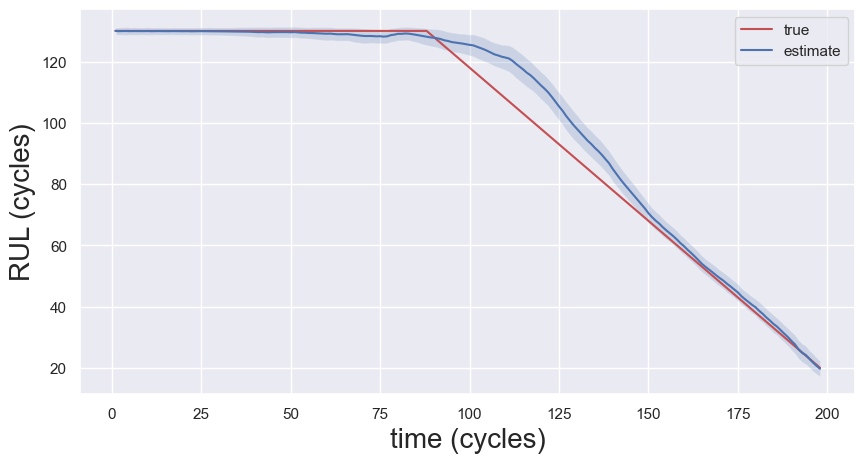

In [43]:
unit = 100
bound = 2 * results["r_stds"][unit-1][0,:,0]
mean = results["r_mean"][unit-1][0,:,0]
t = np.linspace(1, mean.shape[0], mean.shape[0])

plt.figure(figsize=(10,5))
plt.plot(t, results["r_true"][unit-1], label="true", color='r')
plt.plot(t, mean, label="estimate")
plt.fill_between(t, mean - bound, mean + bound, alpha=0.2)
plt.xlabel("time (cycles)", fontsize=20)
plt.ylabel("RUL (cycles)", fontsize=20)
plt.legend()
plt.show()

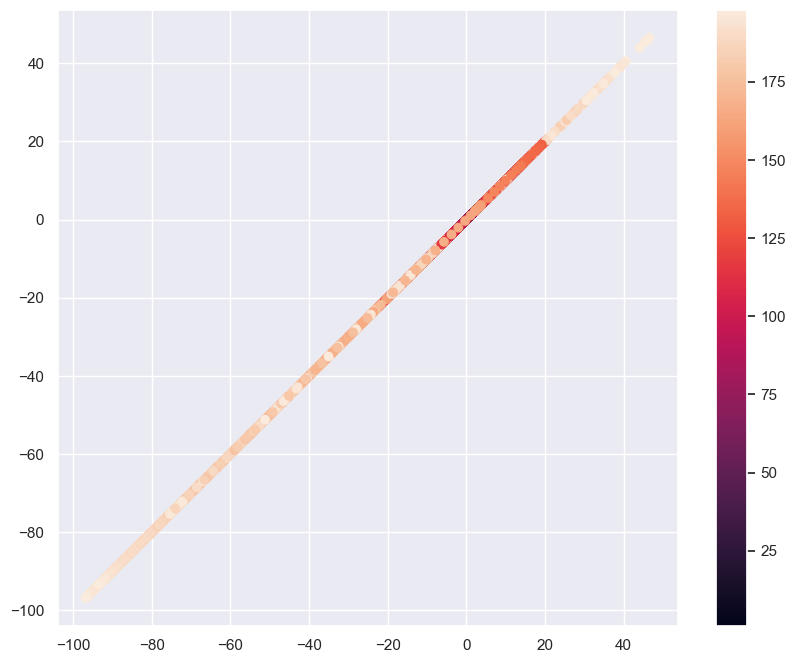

In [44]:
plt.figure(figsize=(10,8))
for i in range(len(results["z_traj"])):
    t = torch.linspace(1, results["z_traj"][i].shape[1], results["z_traj"][i].shape[1])
    plt.scatter(results["z_traj"][i][0,:,0], results["z_traj"][i][0,:,0], c=t)
plt.colorbar()
plt.show()